<a href="https://colab.research.google.com/github/take2rohit/yolov4/blob/master/YoloV4_dataset_converter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset 

1. Download dataset from OpenImage V4 using [OIDv4 toolkit](https://github.com/EscVM/OIDv4_ToolKit)
2. Mount your drive


In [ ]:
!unzip /content/drive/number_plate_yolo.zip 

# visualize random sample output




In [ ]:
import cv2,os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

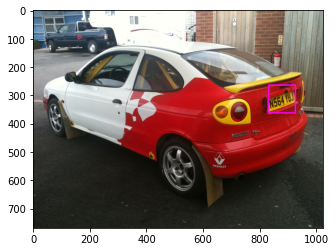

In [ ]:
img_dir = '/content/train/Vehicle registration plate'
label_dir = '/content/train/Label'
files = list(os.listdir(img_dir))

idx = np.random.randint(1,1000)
filename = files[idx]

rand_img_path = os.path.join(img_dir,filename)
abs_label_dir = os.path.join(label_dir,filename[:-3]+'txt')

img = cv2.imread(rand_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

with open(abs_label_dir, "r") as f:
    label = f.read()

label = label.strip().split()

x_top,y_top = int(float(label[3])),int(float(label[4]))
x_bottom,y_bottom = int(float(label[5])),int(float(label[6]))

img = cv2.rectangle(img,(x_top,y_top),(x_bottom,y_bottom),[255,0,255], 3)

plt.imshow(img)
plt.show()

img_h,img_w = img.shape[0], img.shape[1]

x_top_norm, y_top_norm  = x_top//img_w , y_top//img_h
x_bottom_norm, y_bottom_norm  = x_bottom//img_w , y_bottom//img_h

x_center_norm = (x_top_norm + x_bottom_norm) // 2
y_center_norm = (y_top_norm + y_bottom_norm) // 2

# Run this cell to generate labels
Your yolo converted labels will be saved in an autogenerated folder named `yolo_labels`

In [ ]:
!rm -rf yolo_labels/ # REMOVE old folder

In [ ]:
save_folder = 'yolo_labels'
img_dir = '/content/train/Vehicle registration plate'

if not os.path.exists(save_folder):
    os.mkdir(save_folder)

for i, filename in tqdm(enumerate(os.listdir(img_dir))):

    rand_img_path = os.path.join(img_dir,filename)
    abs_label_dir = os.path.join(label_dir,filename[:-3]+'txt')

    img = cv2.imread(rand_img_path)
    img_h,img_w = img.shape[0], img.shape[1]

    with open(abs_label_dir, "r") as f:
        label = f.read()

    label = label.strip().split()

    x_top,y_top = int(float(label[3])),int(float(label[4]))
    x_bottom,y_bottom = int(float(label[5])),int(float(label[6]))

    x_top_norm, y_top_norm  = x_top/img_w , y_top/img_h
    x_bottom_norm, y_bottom_norm  = x_bottom/img_w , y_bottom/img_h

    x_center_norm = (x_top_norm + x_bottom_norm) / 2
    y_center_norm = (y_top_norm + y_bottom_norm) / 2

    h = abs(x_top_norm-x_bottom_norm)  
    w = abs(y_top_norm-y_bottom_norm)

    with open(os.path.join(save_folder,filename[:-3]+'txt'), "w") as f:
        f.write(f'0 {x_center_norm} {y_center_norm} {w} {h}')

In [ ]:
!zip -r plate_converted_yolo_labels.zip yolo_labels/ #Zip the folder

In [ ]:
!cp plate_converted_yolo_labels.zip /content/drive/My\ Drive/number_plate #save to drive

# Download data for YOLOv4 Model

1. Label your data in accordance with YOLO format.
2. Download YOLOv4 from [Darknet](https://github.com/AlexeyAB/darknet).
3. Download pre - trained weights from [here](https://drive.google.com/file/d/1JKF-bdIklxOOVy-2Cr5qdvjgGpmGfcbp/view). Save it in ```darknet-master```

# Tuning YOLOv4 Parameters

1. Make a copy of ```darknet-master/cfg/yolov4-custom.cfg``` and rename the file as ```yolo-custom.cfg```.
2. Open ```yolo-custom.cfg```. Change ```max_batches``` value to **classes $\times$ 2000**. Change line steps to **(0.8 $\times$ ```max_batches```, 0.9 $\times$ ```max_matches```)**. Set network size width and height as 416. Change ```classes = 80``` to the number of classes present at each position in file. Change ```filters = 255``` value to (classes + 5) $\times$ 3 at each position in file.
3. Create a text file ```darknet-master/data/obj.names``` and write name of each class on separate line.
4.  Create a text file ```darknet-master/data/obj.data``` and write the following,
```
classes = # of classes
train = /data/train.txt
names = /data/obj.names
backup = backup/
```

5. Create a text file ```darknet-master/data/train.txt``` and store the image location at each line. For example,
```
data/obj/img1.jpg
data/obj/img2.jpg
data/obj/img3.jpg
data/obj/img4.jpg
..
..
```
6. In ```darknet-master/Makefile```, change the required parameters for your system as,
```
GPU=1
CUDNN=1
CUDNN_HALF=0
OPENCV=1
AVX=0
OPENMP=0
LIBSO=0
ZED_CAMERA=0 # ZED SDK 3.0 and above
ZED_CAMERA_v2_8=0 # ZED SDK 2.X 
```
7. Upload ```darknet-master``` on Google Drive.

# Training

The images and labels from dataset are moved to YOLOv4 model directory.

In [ ]:
%cd "/content/drive/darknet-master/data/"
%mkdir obj

In [ ]:
labellist = os.listdir('/content/train/yolo_labels')
imglist = os.listdir(img_dir)

In [ ]:
import shutil

for label in labellist:
  shutil.move(label,'/content/drive/darknet-master/data/obj')

for images in imglist:
  shutil.move(images,'/content/drive/darknet-master/data/obj')

In [ ]:
% cd "/content/drive/darknet-master"

Compile darknet with the following commands.

In [ ]:
!make
!chmod +x ./darknet

Execute the cell below to start training.

In [ ]:
! ./darknet detector train data/obj.data cfg/yolo-obj.cfg yolov4.conv.137 -dont_show

In case the training is stopped for some reason, the model is continuously being saved in backup folder. To resume training, execute the following cell.

In [ ]:
!./darknet detector train data/obj.data cfg/yolo-obj.cfg backup/yolo-obj_last.weights -dont_show

To prevent colab from disconnecting during inactivity, press ```ctrl + shift + i``` and paste the commands below.
```
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}setInterval(ClickConnect,60000)
```


# Testing

In [ ]:
!./darknet detector test data/obj.data cfg/yolo-obj.cfg backup/yolo-obj_12000.weights

After the cell is executed, enter the image directory. The result is stored as ```prediction.jpg``` in ```darknet-master```.